# Are we consuming more local?

## Research questions

1. Where are the products we consume in our everyday life coming from?

    - Which countries produce the primary resources (ground ingredients) consumed in Switzerland?
    - Which countries manufacture most of the products consumed in Switzerland?


2. Is there a trend over time to consume more local products?

    - Are new products mostly using primary resources from Switzerland? Or from other countries inside Europe?
    - Are new products mostly manufactured in Switzerland? Or from other countries inside Europe?
    - Is there a trend over time to local products to promote their origin?

## Datasets

Open Food Facts (https://world.openfoodfacts.org/data)

Additional datasets “Evolution de la consommation de denrées alimentaires en Suisse” (https://opendata.swiss/fr/dataset/entwicklung-des-nahrungsmittelverbrauches-in-der-schweiz-je-kopf-und-jahr1) and “Dépenses fédérales pour l’agriculture et l’alimentation” (https://opendata.swiss/fr/dataset/bundesausgaben-fur-die-landwirtschaft-und-die-ernahrung1) from https://opendata.swiss/fr/group/agriculture

## TODO

   - Cleaning/Exploring dataset
   - Descriptive analysis
   - We should determine the list of products that are sold in Switzerland
   - We should then classify these products under different categories:
        - products entirely originating from Switzerland
        - products partially originating from Switzerland (manufactured in Switzerland but ingredients are from another country)
        - products not originating from Switzerland
   - Draw statistics from the importation balances, determining which are the countries producing most of the ground ingredients and manufacturing the products consumed in Switzerland.


In [9]:
#imports
import re
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt

import findspark
findspark.init()
import pyspark

from pyspark.sql import *
from pyspark.sql import functions as F
from pyspark.sql import SQLContext
from pyspark.sql.functions import *
from pyspark.sql.functions import min
from pyspark.sql.functions import to_date, last_day,date_add
from datetime import timedelta

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [2]:
DATA_FOLDER = 'data'

In [13]:
dataset = pd.read_csv(DATA_FOLDER+"/en.openfoodfacts.org.products.csv", sep='\t')

/anaconda3/envs/ada/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (0,3,5,24,25,26,28,36,41,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [15]:
dataset.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,0000000000017,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1529059080,2018-06-15T10:38:00Z,1529059204,2018-06-15T10:40:04Z,Vitória crackers,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000000031,http://world-en.openfoodfacts.org/product/0000...,isagoofy,1539464774,2018-10-13T21:06:14Z,1539464817,2018-10-13T21:06:57Z,Cacao,NaN,130 g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0000000000123,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1535737982,2018-08-31T17:53:02Z,1535737986,2018-08-31T17:53:06Z,Sauce Sweety chili 0%,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0000000000291,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1534239669,2018-08-14T09:41:09Z,1534239732,2018-08-14T09:42:12Z,Mendiants,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0000000000949,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1523440813,2018-04-11T10:00:13Z,1523440823,2018-04-11T10:00:23Z,Salade de carottes râpées,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
dataset_main = spark.read.csv(DATA_FOLDER+"/en.openfoodfacts.org.products.csv", header=True, mode="DROPMALFORMED", sep = '\t')

In [46]:
dataset_main.printSchema()

root
 |-- code: string (nullable = true)
 |-- url: string (nullable = true)
 |-- creator: string (nullable = true)
 |-- created_t: string (nullable = true)
 |-- created_datetime: string (nullable = true)
 |-- last_modified_t: string (nullable = true)
 |-- last_modified_datetime: string (nullable = true)
 |-- product_name: string (nullable = true)
 |-- generic_name: string (nullable = true)
 |-- quantity: string (nullable = true)
 |-- packaging: string (nullable = true)
 |-- packaging_tags: string (nullable = true)
 |-- brands: string (nullable = true)
 |-- brands_tags: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- categories_tags: string (nullable = true)
 |-- categories_en: string (nullable = true)
 |-- origins: string (nullable = true)
 |-- origins_tags: string (nullable = true)
 |-- manufacturing_places: string (nullable = true)
 |-- manufacturing_places_tags: string (nullable = true)
 |-- labels: string (nullable = true)
 |-- labels_tags: string (nullable 

In [41]:
#Additional datasets “Evolution de la consommation de denrées alimentaires en Suisse”
df_ev_conso = pd.read_excel(DATA_FOLDER+"/je-f-07.06.02.xlsx", header=4, sheet_name='Dès 2007')
df_ev_conso = df_ev_conso.dropna(how='all')

In [43]:
#Additional datasets “Dépenses fédérales pour l’agriculture et l’alimentation” 
dep_fed_al = pd.read_excel(DATA_FOLDER+"/je-f-07.02.03.02.04.xlsx", header=3, sheet_name='T 07.02.03.02.04')
dep_fed_al = dep_fed_al.dropna(how='all')

In [84]:
#For the sake of the project, we will focus on features related to the origin of the manufacture and ingredients of the products
dataset_main.createOrReplaceTempView("data_main")
focus_df = spark.sql("SELECT product_name, brands, brands_tags, categories, categories_tags, origins, origins_tags, manufacturing_places, manufacturing_places_tags,labels,labels_tags,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags FROM data_main")
#focus_df.show()

In [105]:
#store products that are sold in Switzerland
swiss_sold_data = focus_df.filter("countries REGEXP 'Switzerland|Suisse|Schweiz|Svizerra'")
#store products which ingredients originate from Switzerland
swiss_origin_data = focus_df.filter("origins REGEXP 'Switzerland|Suisse|Schweiz|Svizerra'")
#store products that are manufactured in Switzerland
swiss_manu_data = focus_df.filter("manufacturing_places REGEXP 'Switzerland|Suisse|Schweiz|Svizerra'")
#store products that are both manufactured and originate from Switzerland
swiss_origin_manu_data = focus_df.filter("(origins REGEXP 'Switzerland|Suisse|Schweiz|Svizerra') AND (manufacturing_places REGEXP 'Switzerland|Suisse|Schweiz|Svizerra')")

In [112]:
########DATA PREPARATION FOR PIE########
#
#count products whose ingredients from switzerland but which were not manufactured in Switzerland
swiss_origin_tot = swiss_origin_data.filter("manufacturing_places !REGEXP 'Switzerland|Suisse|Schweiz|Svizerra'").count()
#Total of products sold in Switzerland
swiss_sold_tot = swiss_sold_data.count()
#count products that do not have swiss ingredients
swiss_manu_tot = swiss_manu_data.filter("origins !REGEXP 'Switzerland|Suisse|Schweiz|Svizerra'").count()
#products that are sold in Switzerland but that were not manufactured in CH and that do not have swiss ingredients
non_swiss_sold_tot = swiss_sold_data.filter("manufacturing_places !REGEXP 'Switzerland|Suisse|Schweiz|Svizerra' AND origins !REGEXP 'Switzerland|Suisse|Schweiz|Svizerra'").count()
#total of products that are both manufactured and has ingredients from Switzerland
swiss_origin_manu_tot = swiss_origin_manu_data.count()


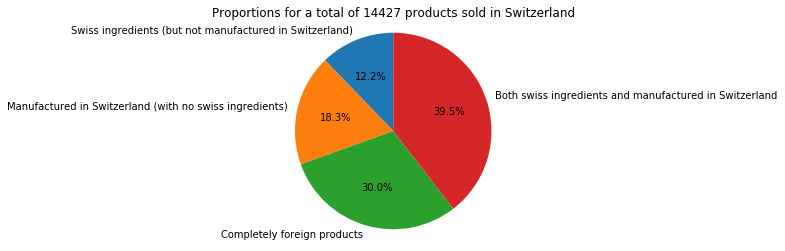

In [126]:
labels = 'Swiss ingredients (but not manufactured in Switzerland)', 'Manufactured in Switzerland (with no swiss ingredients)', 'Completely foreign products', 'Both swiss ingredients and manufactured in Switzerland'
sizes = [swiss_origin_tot, swiss_manu_tot, non_swiss_sold_tot, swiss_origin_manu_tot]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Proportions for a total of ' + str(swiss_sold_tot) + ' products sold in Switzerland')

plt.show()